In [2]:
import numpy as np
import corner
import time
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LightModel.light_model import LightModel
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Util import kernel_util, image_util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot

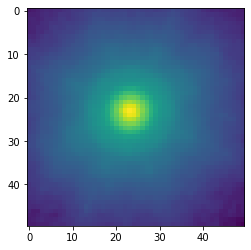

In [14]:
# =================setting args=====================
center_x = 0
center_y = 0
point_amp = 1
background_rms = 0.5
exp_time = 398226
numPix = 50
deltaPix = 0.06

# =================setting model====================
point_source_list = ['UNLENSED']
pointSource = PointSource(point_source_type_list=point_source_list)
kwargs_ps = [{'ra_image': [center_x], 'dec_image': [center_y],
              'point_amp': [point_amp]}]
light_model_list = ['SERSIC_ELLIPSE']
lightModel = LightModel(light_model_list=light_model_list)

# =================setting kwargs_data==============
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
image = pyfits.getdata('3D-HST/cutouts/goodss/13_3dhst_25091F125W.fits')
kwargs_data['image_data'] = image

poisson = image_util.add_poisson(image, exp_time=exp_time)
image = image - poisson
plt.imshow(np.log10(image))

# =================setting psf======================
fwhm = 0.1
psf_type = 'PIXEL'
kernel_size = 69
kernel = pyfits.getdata('3D-HST/PSF_image/GOODS-S/F125W_psf.fits')
# plt.imshow(np.log10(kernel))
kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf = {
    'psf_type': psf_type,
    'fwhm': fwhm,
    'kernel_point_source': kernel_cut,
    'pixel_size': deltaPix
}

# ==================setting kwargs_numerics=========
supersampled_indexes = np.zeros((numPix, numPix), dtype=bool)
supersampled_indexes[int(numPix/2)-1:int(numPix/2)+1, int(numPix/2)-1:int(numPix/2)+1] = True
kwargs_numerics = {
    'supersampling_factor': 8,
    'compute_mode': 'adaptive',
    'supersampled_indexes': supersampled_indexes
}

# ==================setting fitting constraints=====================
# here are the options for the host galaxy fitting
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

# Disk component, as modelled by an elliptical Sersic profile
fixed_source.append({'n_sersic': 1})  # we fix the Sersic index to n=1 (exponential)
kwargs_source_init.append({'R_sersic': 1., 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.5, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

# Buldge component, as modelled by a spherical Sersic profile
'''fixed_source.append({'n_sersic': 4})  # we fix the Sersic index to n=4 (buldgy)
kwargs_source_init.append({'R_sersic': .5, 'n_sersic': 4, 'center_x': 0, 'center_y': 0})
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.3, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})'''

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

fixed_ps = [{}]
kwargs_ps_init = kwargs_ps
kwargs_ps_sigma = [{'ra_image': [0.01], 'dec_image': [0.01]}]
kwargs_lower_ps = [{'ra_image': [-10], 'dec_image': [-10]}]
kwargs_upper_ps = [{'ra_image': [10], 'dec_image': [10]}]

ps_param = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_light_model': source_params, 'point_source_model': ps_param}

# =========================fitting params set=======================================
kwargs_model = {'lens_light_model_list': light_model_list,
                'point_source_model_list': point_source_list}

# numerical options and fitting sequences
# further parameter handling options can be found in the Param() class description.

kwargs_constraints = {# 'joint_lens_light_with_lens_light': [[0, 1, ['center_x', 'center_y']]],
                      'joint_lens_light_with_point_source': [[0, 0]],
                      'num_point_source_list': [1]
                     }

kwargs_likelihood = {'check_bounds': True,
                     'source_marg': False,
                     'check_positive_flux': True
                             }
image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

mpi = False  # MPI possible, but not supported through that notebook.

Computing the PSO ...
10
20
30
40
50
60
70
80
Converged after 80 iterations!
Best fit found:  -199.20780993346384 [0.5792323541394471, 0.07248097203023963, -0.06561665687236665, -0.07851436488768979, -0.07888305174857614]
-0.15981372638063684 reduced X^2 of best position
-199.20780993346384 logL
2493.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.5792323541394471, 'n_sersic': 1, 'e1': 0.07248097203023963, 'e2': -0.06561665687236665, 'center_x': -0.07851436488768979, 'center_y': -0.07888305174857614}] lens light result
[{'ra_image': array([-0.07851436]), 'dec_image': array([-0.07888305]), 'point_amp': array([1.])}] point source result
{} special param result
57.04687285423279 time used for  PSO


100%|██████████████████████████████████████████████████████| 200/200 [01:04<00:00,  3.12it/s]


Computing the MCMC...
Number of walkers =  50
Burn-in iterations:  100
Sampling iterations (in current run): 200
64.56653499603271 time taken for MCMC sampling
121.70352506637573 total time needed for computation
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 
-0.1593870069438036 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.15938700694380345


/home/yuhr/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:533: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data - model), origin='lower', vmin=v_min, vmax=v_max,


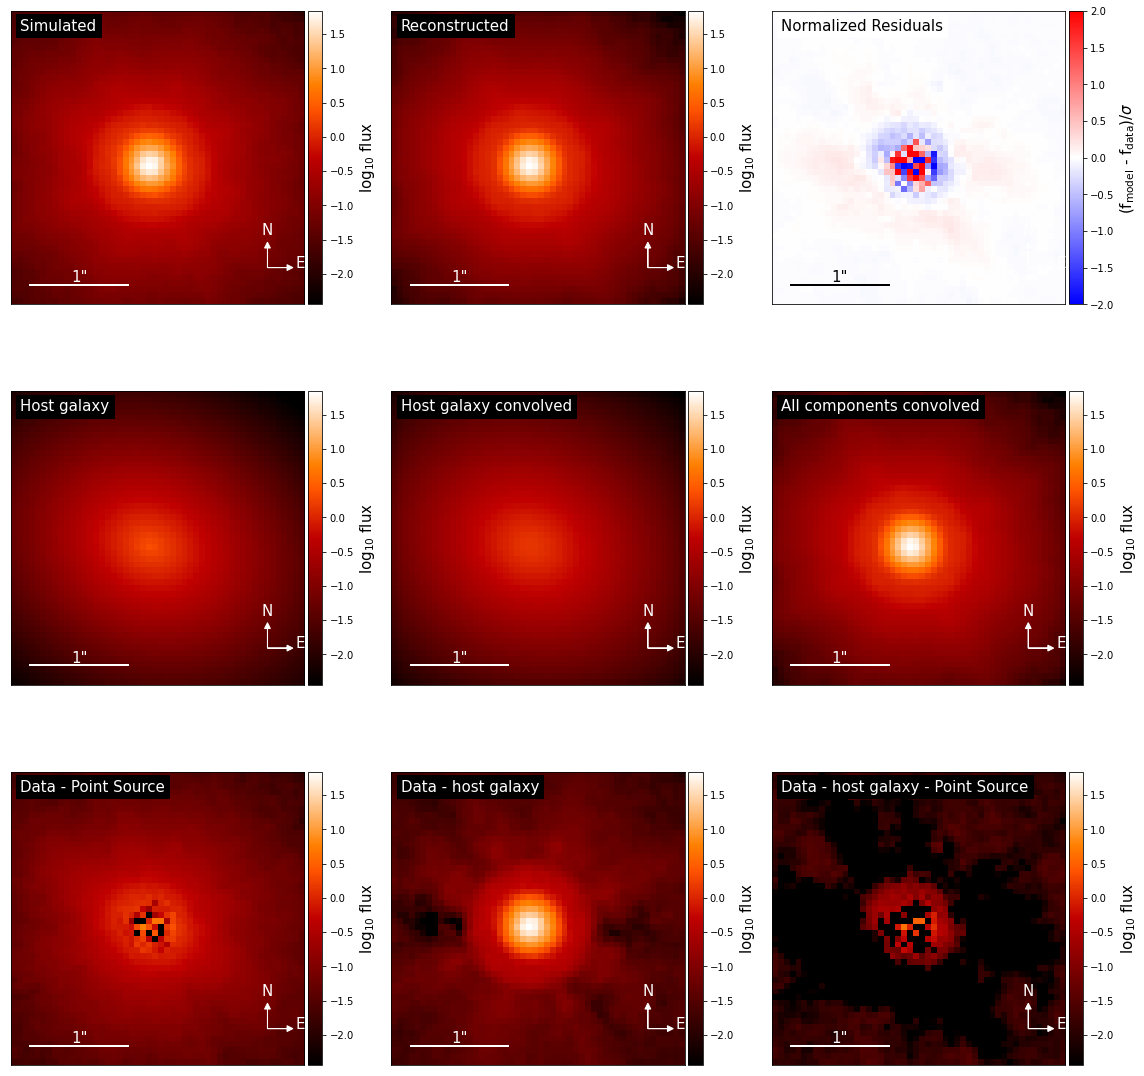

/tmp/ipykernel_27820/2145624194.py:44: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


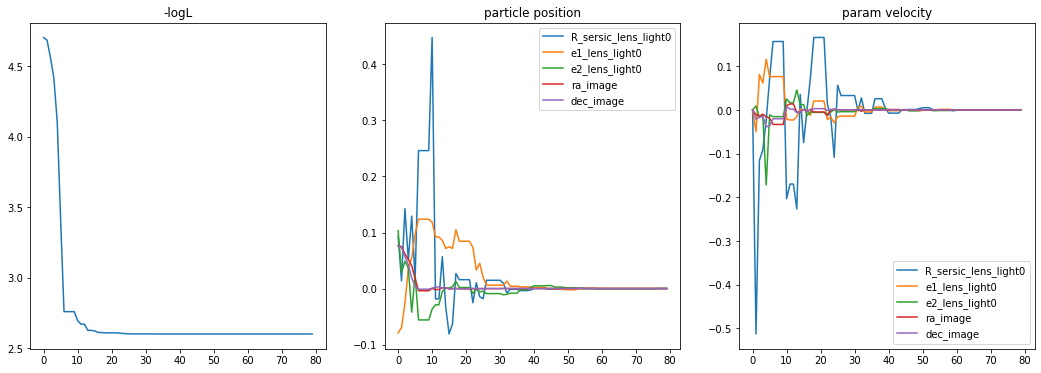

<Figure size 432x288 with 0 Axes>

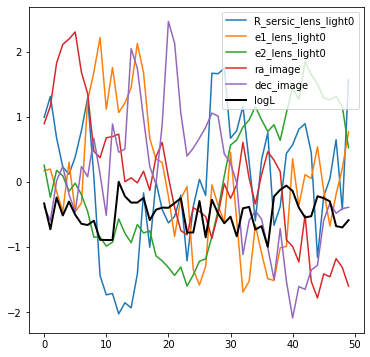

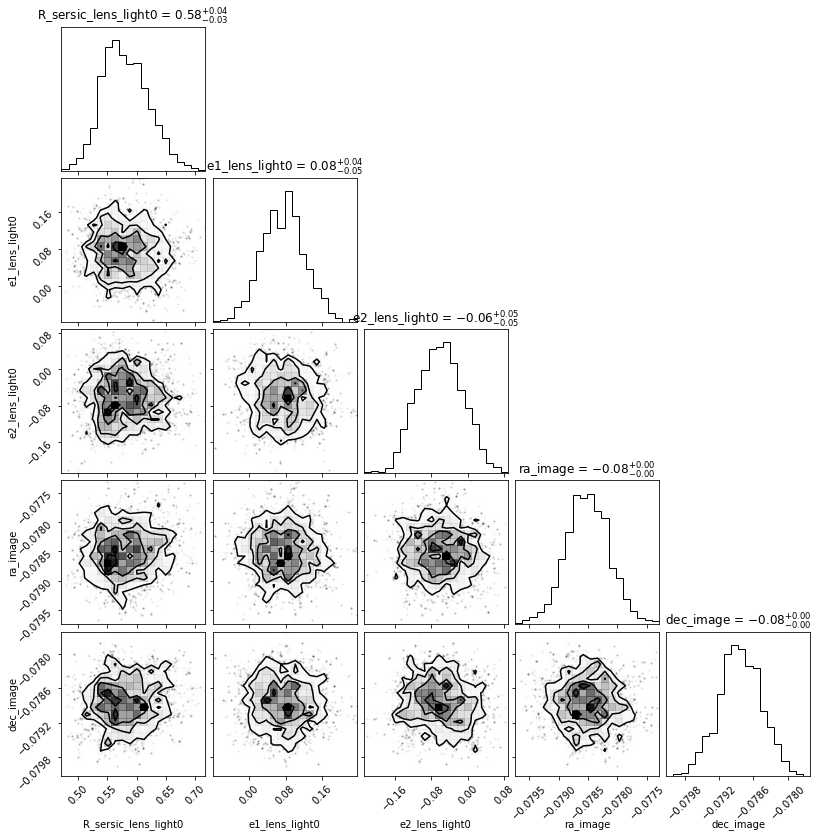

In [15]:
# fitting sequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100}],
                       ['MCMC', {'n_burn': 100, 'n_run': 100, 'walkerRatio': 10,'sigma_scale': .1}]]

start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

# let's plot the output of the PSO minimizer

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(3, 3, figsize=(16, 16), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0], text="Simulated")
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-2, v_max=2)

modelPlot.decomposition_plot(ax=axes[1,0], text='Host galaxy', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Host galaxy convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)

modelPlot.subtract_from_data_plot(ax=axes[2,0], text='Data - Point Source', point_source_add=True)
modelPlot.subtract_from_data_plot(ax=axes[2,1], text='Data - host galaxy', lens_light_add=True)
modelPlot.subtract_from_data_plot(ax=axes[2,2], text='Data - host galaxy - Point Source', lens_light_add=True, point_source_add=True)

f.tight_layout()
#f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()



# here the (non-converged) MCMC chain of the non-linear parameters
for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

if not samples_mcmc == []:
        n, num_param = np.shape(samples_mcmc)
        plot = corner.corner(samples_mcmc, labels=param_mcmc, show_titles=True)

/tmp/ipykernel_23804/2789430020.py:25: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(image))


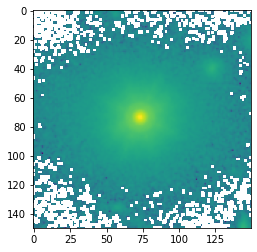

In [45]:
# =================setting args=====================
center_x = 0
center_y = 0
point_amp = 1
background_rms = 0.05
exp_time = 398226
numPix = 150
deltaPix = 0.06

# =================setting model====================
point_source_list = ['UNLENSED']
pointSource = PointSource(point_source_type_list=point_source_list)
kwargs_ps = [{'ra_image': [center_x], 'dec_image': [center_y],
              'point_amp': [point_amp]}]
light_model_list = ['SERSIC_ELLIPSE']
lightModel = LightModel(light_model_list=light_model_list)

# =================setting kwargs_data==============
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
image = pyfits.getdata('big.fits')
kwargs_data['image_data'] = image

poisson = image_util.add_poisson(image, exp_time=exp_time)
image = image - poisson
plt.imshow(np.log10(image))

# =================setting psf======================
fwhm = 0.1
psf_type = 'PIXEL'
kernel_size = 69
kernel = pyfits.getdata('3D-HST/PSF_image/GOODS-S/F125W_psf.fits')
# plt.imshow(np.log10(kernel))
kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf = {
    'psf_type': psf_type,
    'fwhm': fwhm,
    'kernel_point_source': kernel_cut,
    'pixel_size': deltaPix
}

# ==================setting kwargs_numerics=========
supersampled_indexes = np.zeros((numPix, numPix), dtype=bool)
supersampled_indexes[int(numPix/2)-1:int(numPix/2)+1, int(numPix/2)-1:int(numPix/2)+1] = True
kwargs_numerics = {
    'supersampling_factor': 4,
    'compute_mode': 'adaptive',
    'supersampled_indexes': supersampled_indexes
}

# ==================setting fitting constraints=====================
# here are the options for the host galaxy fitting
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

# Disk component, as modelled by an elliptical Sersic profile
fixed_source.append({'n_sersic': 1})  # we fix the Sersic index to n=1 (exponential)
kwargs_source_init.append({'R_sersic': 1., 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.5, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

# Buldge component, as modelled by a spherical Sersic profile
'''fixed_source.append({'n_sersic': 4})  # we fix the Sersic index to n=4 (buldgy)
kwargs_source_init.append({'R_sersic': .5, 'n_sersic': 4, 'center_x': 0, 'center_y': 0})
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.3, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})'''

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

fixed_ps = [{}]
kwargs_ps_init = kwargs_ps
kwargs_ps_sigma = [{'ra_image': [0.01], 'dec_image': [0.01]}]
kwargs_lower_ps = [{'ra_image': [-10], 'dec_image': [-10]}]
kwargs_upper_ps = [{'ra_image': [10], 'dec_image': [10]}]

ps_param = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_light_model': source_params, 'point_source_model': ps_param}

# =========================fitting params set=======================================
kwargs_model = {'lens_light_model_list': light_model_list,
                'point_source_model_list': point_source_list}

# numerical options and fitting sequences
# further parameter handling options can be found in the Param() class description.

kwargs_constraints = {# 'joint_lens_light_with_lens_light': [[0, 1, ['center_x', 'center_y']]],
                      'joint_lens_light_with_point_source': [[0, 0]],
                      'num_point_source_list': [1]
                     }

kwargs_likelihood = {'check_bounds': True,
                     'source_marg': False,
                     'check_positive_flux': True
                             }
image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

mpi = False  # MPI possible, but not supported through that notebook.

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.7513861594823483 reduced X^2 of best position
-19696.96444261823 logL
22493.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.5883255484451737, 'n_sersic': 1, 'e1': 0.07233244931862992, 'e2': -0.06621368989661884, 'center_x': -0.07849215922232695, 'center_y': -0.07888264913938825}] lens light result
[{'ra_image': array([-0.07849216]), 'dec_image': array([-0.07888265]), 'point_amp': array([1.])}] point source result
{} special param result
82.81399202346802 time used for  PSO


100%|██████████████████████████████████████████████████████| 200/200 [01:16<00:00,  2.61it/s]
/home/yuhr/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: invalid value encountered in log10
  log_model = np.log10(model)
/home/yuhr/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/home/yuhr/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,


Computing the MCMC...
Number of walkers =  50
Burn-in iterations:  100
Sampling iterations (in current run): 200
76.88489174842834 time taken for MCMC sampling
159.76943683624268 total time needed for computation
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 
-1.750847494966163 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.750847494966163


/home/yuhr/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:506: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,
/home/yuhr/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:533: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data - model), origin='lower', vmin=v_min, vmax=v_max,


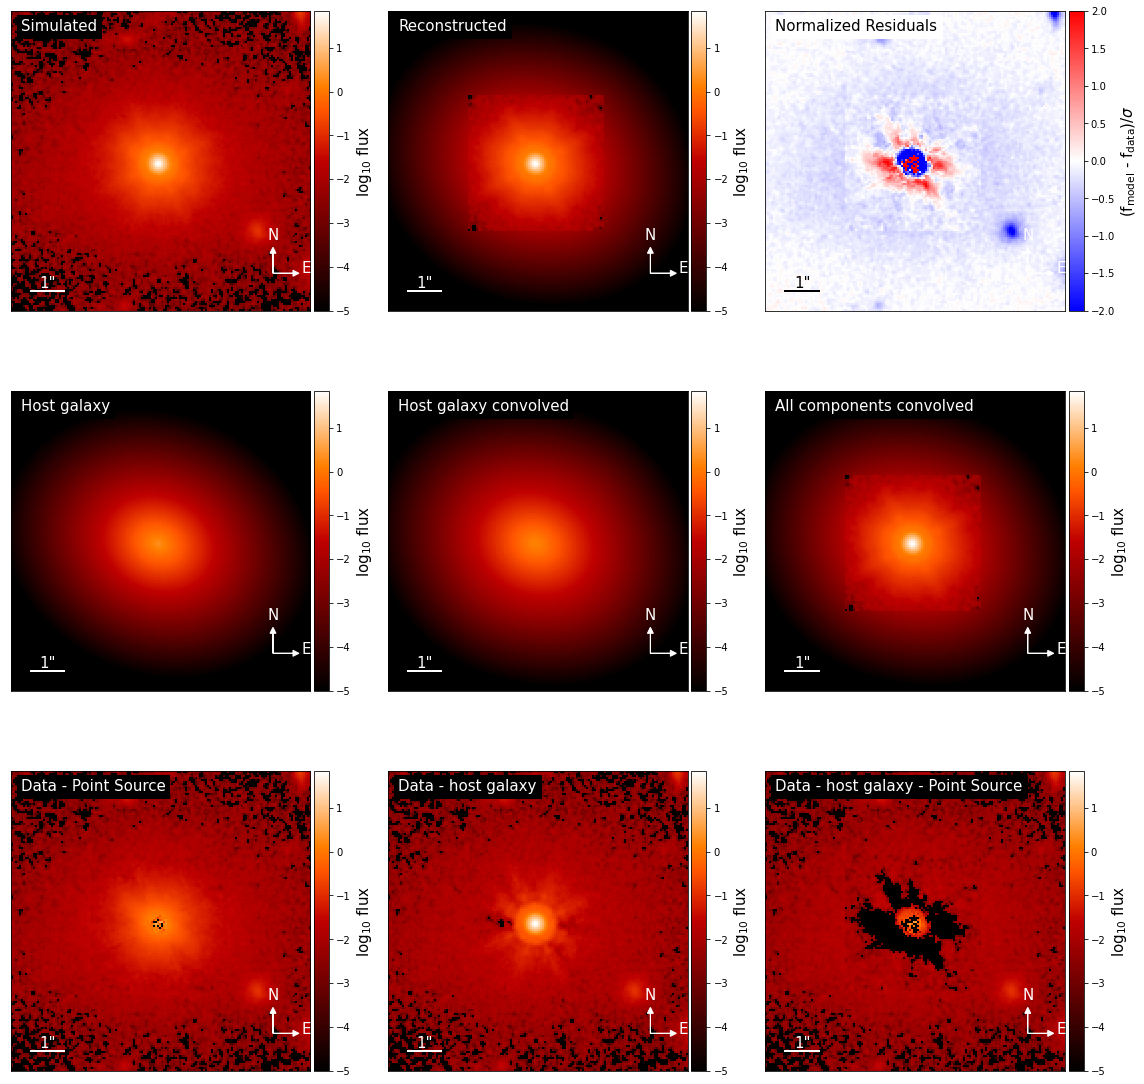

/tmp/ipykernel_23804/2145624194.py:44: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


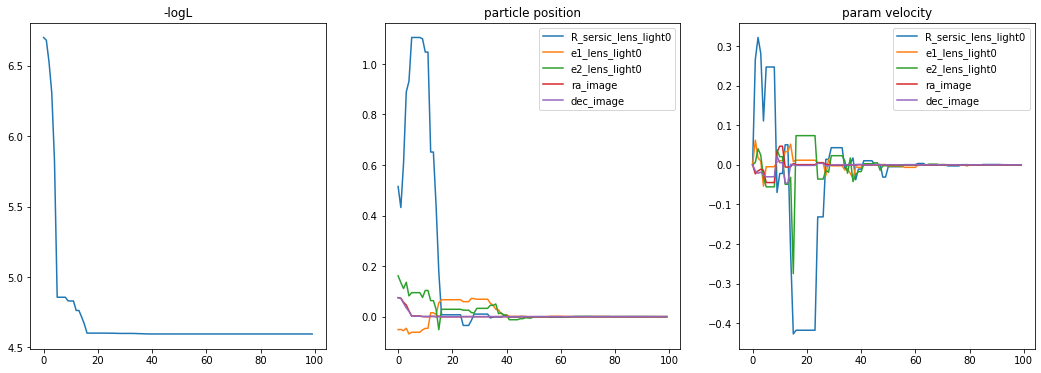

<Figure size 432x288 with 0 Axes>

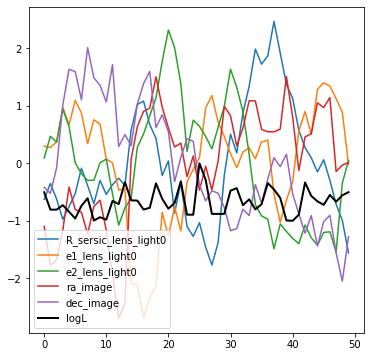

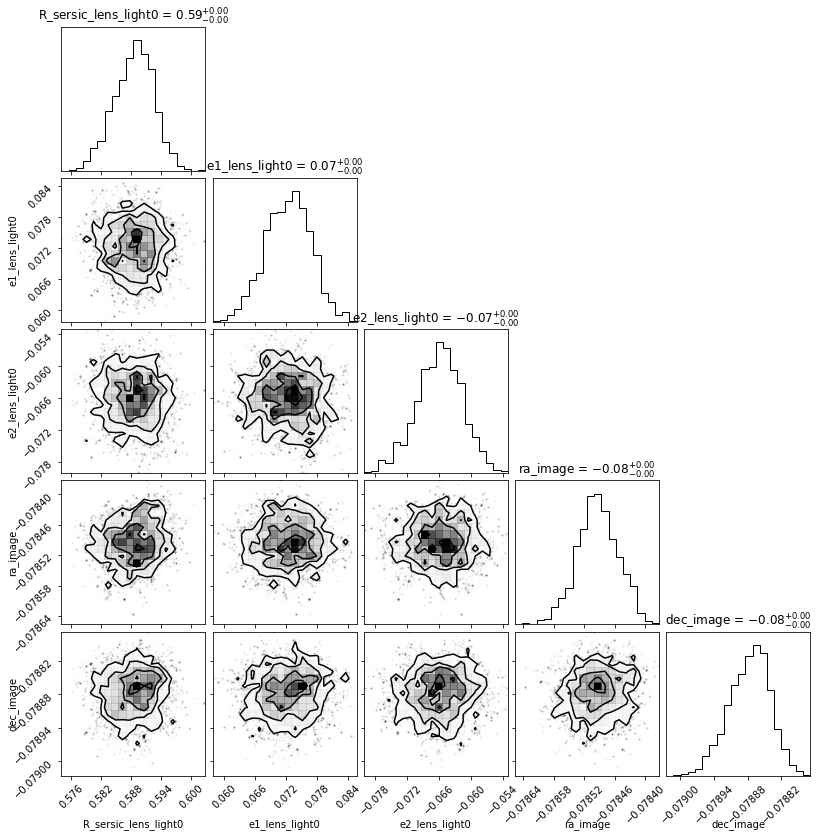

In [46]:
# fitting sequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100}],
                       ['MCMC', {'n_burn': 100, 'n_run': 100, 'walkerRatio': 10,'sigma_scale': .1}]]

start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

# let's plot the output of the PSO minimizer

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(3, 3, figsize=(16, 16), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0], text="Simulated")
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-2, v_max=2)

modelPlot.decomposition_plot(ax=axes[1,0], text='Host galaxy', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Host galaxy convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)

modelPlot.subtract_from_data_plot(ax=axes[2,0], text='Data - Point Source', point_source_add=True)
modelPlot.subtract_from_data_plot(ax=axes[2,1], text='Data - host galaxy', lens_light_add=True)
modelPlot.subtract_from_data_plot(ax=axes[2,2], text='Data - host galaxy - Point Source', lens_light_add=True, point_source_add=True)

f.tight_layout()
#f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()



# here the (non-converged) MCMC chain of the non-linear parameters
for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

if not samples_mcmc == []:
        n, num_param = np.shape(samples_mcmc)
        plot = corner.corner(samples_mcmc, labels=param_mcmc, show_titles=True)

std=0.005150


/tmp/ipykernel_23804/3134623419.py:11: RuntimeWarning: invalid value encountered in log10
  ax[0].imshow(np.log10(image), origin='lower')


Text(0.5, 1.0, 'mask')

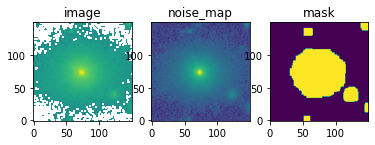

In [101]:
from photutils.segmentation import make_source_mask
from astropy.stats import sigma_clipped_stats
# detect and mask sources in the image
mask = make_source_mask(image, nsigma=2, npixels=2, dilate_size=10)
# calculate STandard Deviation
mean, median, std = sigma_clipped_stats(image, sigma=3.0, mask=mask)
print("std=%f" %std)
# calculate noise_map in the way given in galight docs
noise_map = np.sqrt(abs(image/exp_time)) + std**2
fig, ax = plt.subplots(1, 3)
ax[0].imshow(np.log10(image), origin='lower')
ax[0].set_title('image')
ax[1].imshow(np.log10(noise_map), origin='lower')
ax[1].set_title('noise_map')
ax[2].imshow(mask, origin='lower')
ax[2].set_title('mask')

/tmp/ipykernel_23804/1150738221.py:26: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(image))


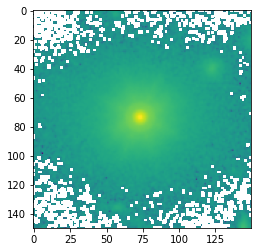

In [85]:
# =================setting args=====================
center_x = 0
center_y = 0
point_amp = 1
background_rms = 0.5
exp_time = 398226
numPix = 150
deltaPix = 0.06

# =================setting model====================
point_source_list = ['UNLENSED']
pointSource = PointSource(point_source_type_list=point_source_list)
kwargs_ps = [{'ra_image': [center_x], 'dec_image': [center_y],
              'point_amp': [point_amp]}]
light_model_list = ['SERSIC_ELLIPSE']
lightModel = LightModel(light_model_list=light_model_list)

# =================setting kwargs_data==============
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
image = pyfits.getdata('big.fits')
kwargs_data['image_data'] = image
kwargs_data['noise_map'] = noise_map

poisson = image_util.add_poisson(image, exp_time=exp_time)
image = image - poisson
plt.imshow(np.log10(image))

# =================setting psf======================
fwhm = 0.1
psf_type = 'PIXEL'
kernel_size = 69
kernel = pyfits.getdata('3D-HST/PSF_image/GOODS-S/F125W_psf.fits')
# plt.imshow(np.log10(kernel))
kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf = {
    'psf_type': psf_type,
    'fwhm': fwhm,
    'kernel_point_source': kernel_cut,
    'pixel_size': deltaPix
}

# ==================setting kwargs_numerics=========
supersampled_indexes = np.zeros((numPix, numPix), dtype=bool)
supersampled_indexes[int(numPix/2)-1:int(numPix/2)+1, int(numPix/2)-1:int(numPix/2)+1] = True
kwargs_numerics = {
    'supersampling_factor': 4,
    'compute_mode': 'adaptive',
    'supersampled_indexes': supersampled_indexes
}

# ==================setting fitting constraints=====================
# here are the options for the host galaxy fitting
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

# Disk component, as modelled by an elliptical Sersic profile
fixed_source.append({'n_sersic': 1})  # we fix the Sersic index to n=1 (exponential)
kwargs_source_init.append({'R_sersic': 1., 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.5, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

# Buldge component, as modelled by a spherical Sersic profile
'''fixed_source.append({'n_sersic': 4})  # we fix the Sersic index to n=4 (buldgy)
kwargs_source_init.append({'R_sersic': .5, 'n_sersic': 4, 'center_x': 0, 'center_y': 0})
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.3, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})'''

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

fixed_ps = [{}]
kwargs_ps_init = kwargs_ps
kwargs_ps_sigma = [{'ra_image': [0.01], 'dec_image': [0.01]}]
kwargs_lower_ps = [{'ra_image': [-10], 'dec_image': [-10]}]
kwargs_upper_ps = [{'ra_image': [10], 'dec_image': [10]}]

ps_param = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_light_model': source_params, 'point_source_model': ps_param}

# =========================fitting params set=======================================
kwargs_model = {'lens_light_model_list': light_model_list,
                'point_source_model_list': point_source_list}

# numerical options and fitting sequences
# further parameter handling options can be found in the Param() class description.

kwargs_constraints = {# 'joint_lens_light_with_lens_light': [[0, 1, ['center_x', 'center_y']]],
                      'joint_lens_light_with_point_source': [[0, 0]],
                      'num_point_source_list': [1]
                     }

kwargs_likelihood = {'check_bounds': True,
                     'source_marg': False,
                     'check_positive_flux': True
                             }
image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

mpi = False  # MPI possible, but not supported through that notebook.

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1463.6221236882593 reduced X^2 of best position
-16460626.214060009 logL
22493.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.9414083323957544, 'n_sersic': 1, 'e1': 0.06899913898663697, 'e2': -0.03963919962407714, 'center_x': -0.07678167074967647, 'center_y': -0.07780958085858371}] lens light result
[{'ra_image': array([-0.07678167]), 'dec_image': array([-0.07780958]), 'point_amp': array([1.])}] point source result
{} special param result
83.4417736530304 time used for  PSO


100%|██████████████████████████████████████████████████████| 200/200 [01:23<00:00,  2.39it/s]
/home/yuhr/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: invalid value encountered in log10
  log_model = np.log10(model)
/home/yuhr/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/home/yuhr/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,


Computing the MCMC...
Number of walkers =  50
Burn-in iterations:  100
Sampling iterations (in current run): 200
84.24002289772034 time taken for MCMC sampling
167.77447509765625 total time needed for computation
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 
-1463.1667815882088 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1463.1667815882088


/home/yuhr/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:506: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,
/home/yuhr/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:533: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data - model), origin='lower', vmin=v_min, vmax=v_max,


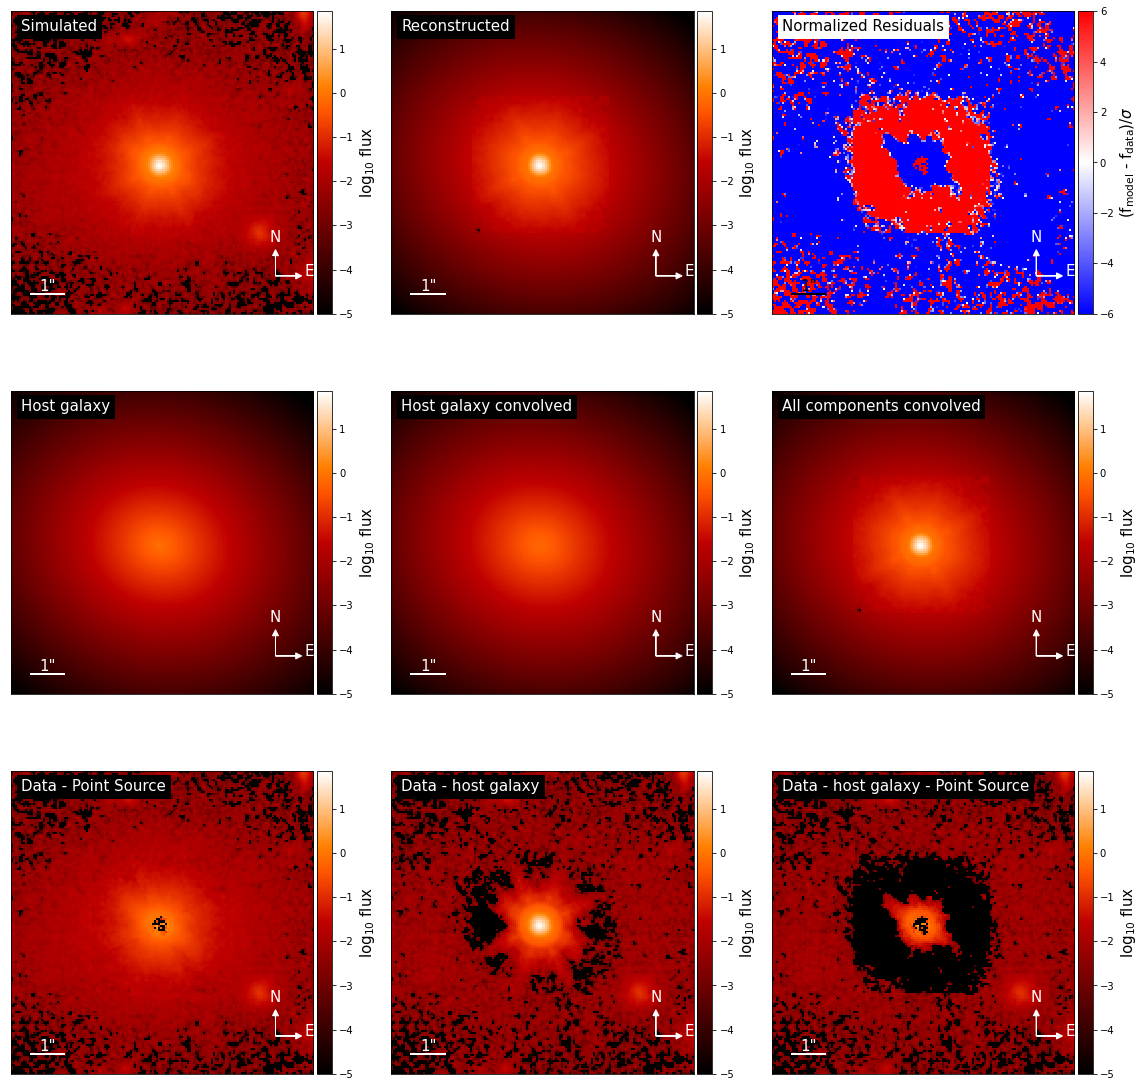

/tmp/ipykernel_23804/2803375572.py:44: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


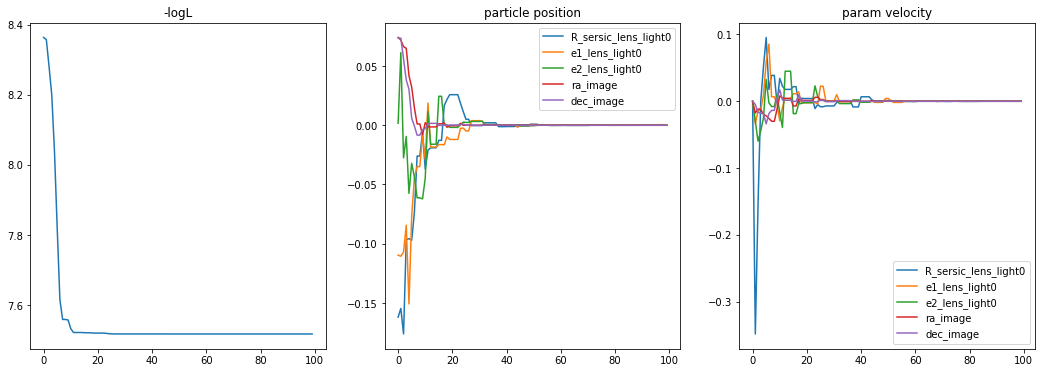

<Figure size 432x288 with 0 Axes>

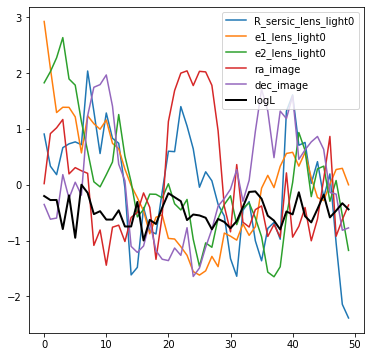

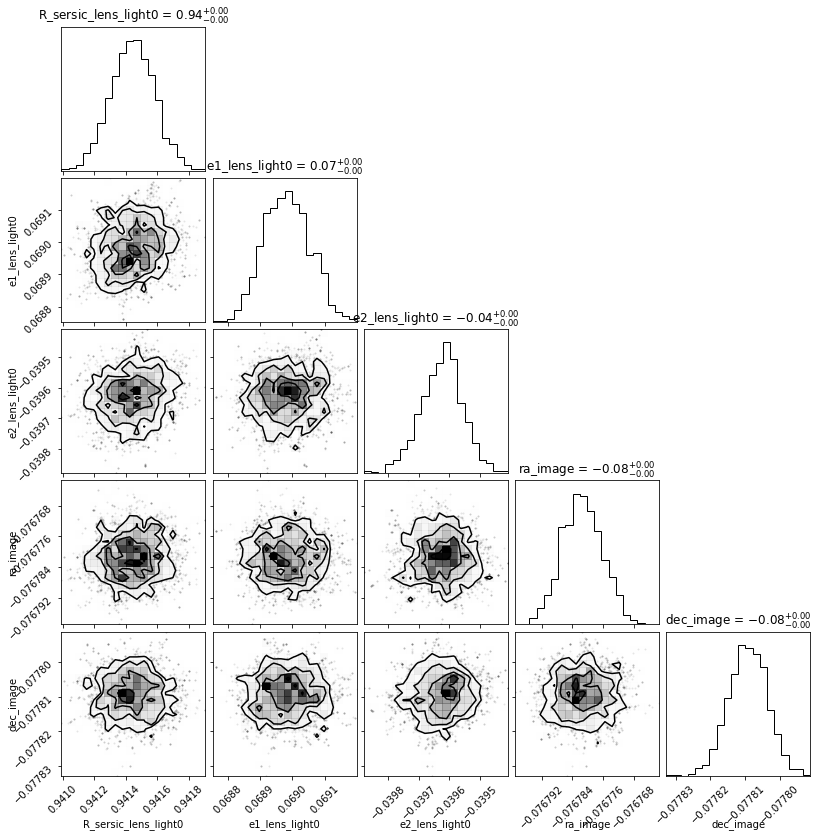

In [86]:
# fitting sequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100}],
                       ['MCMC', {'n_burn': 100, 'n_run': 100, 'walkerRatio': 10,'sigma_scale': .1}]]

start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

# let's plot the output of the PSO minimizer

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(3, 3, figsize=(16, 16), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0], text="Simulated")
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)

modelPlot.decomposition_plot(ax=axes[1,0], text='Host galaxy', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Host galaxy convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)

modelPlot.subtract_from_data_plot(ax=axes[2,0], text='Data - Point Source', point_source_add=True)
modelPlot.subtract_from_data_plot(ax=axes[2,1], text='Data - host galaxy', lens_light_add=True)
modelPlot.subtract_from_data_plot(ax=axes[2,2], text='Data - host galaxy - Point Source', lens_light_add=True, point_source_add=True)

f.tight_layout()
#f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()



# here the (non-converged) MCMC chain of the non-linear parameters
for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

if not samples_mcmc == []:
        n, num_param = np.shape(samples_mcmc)
        plot = corner.corner(samples_mcmc, labels=param_mcmc, show_titles=True)